# RIP.ie daily death data (v2)

* rip.ie
* http://dmnfarrell.github.io/
* https://data.gov.ie/dataset/list-of-nursing-homes-in-ireland/resource/489aad00-cad1-41d7-92bf-8b5cdd9d61ea
* https://data.gov.ie/dataset/62954fa3-1492-48af-93d1-5c9bf6a14d1e/resource/142d3b64-8f02-4ed7-bfbd-dc3e20420f3f#&r=C01885V02316&c=STATISTIC


In [64]:
import pandas as pd
import pylab as plt
import numpy as np
import seaborn as sns
import matplotlib as mpl
import pylab as plt
import matplotlib.dates as mdates
import difflib, re

pd.set_option('display.width', 150)
locator = mdates.AutoDateLocator(minticks=4, maxticks=10)
formatter = mdates.ConciseDateFormatter(locator)
sns.set_style("white")
sns.set_context('talk')
pd.set_option('display.max_colwidth', 500)

In [65]:
def get_data(dups=False):
    
    df = pd.read_pickle('rip_dn_scrape_processed.pkl')
    df=df.dropna(subset=['date'])
    if dups==False:
        df=df.drop_duplicates(['name','date','county'])
    print (len(df))    
    df['date'] = pd.to_datetime(df.date,format='%d/%m/%Y',errors='coerce')
    df['name'] = df.name.replace('  ',' ')
    df.index=df.index.astype('int')
    df.sort_index()
    df['year'] = df.date.dt.year.astype(int)
    df['month'] = df.date.dt.month
    df['day'] = df.date.dt.dayofyear
    df['week'] = df.date.dt.isocalendar().week
    #df['week'] = df.date.dt.strftime('%W').astype('int')
    df['year-week'] = df.date.dt.strftime('%Y-W%U')
    return df

df = get_data()
df = df[df.year>=2008]

453636


In [ ]:
df[(df.week==53) & (df.year==2021)]

     year  week  name
547  2018    24   573
548  2018    25   531
549  2018    26   609
550  2018    27   594
551  2018    28   532
..    ...   ...   ...
717  2021    37   619
718  2021    38   667
719  2021    39   743
720  2021    40   667
721  2021    41   688

[72 rows x 3 columns]


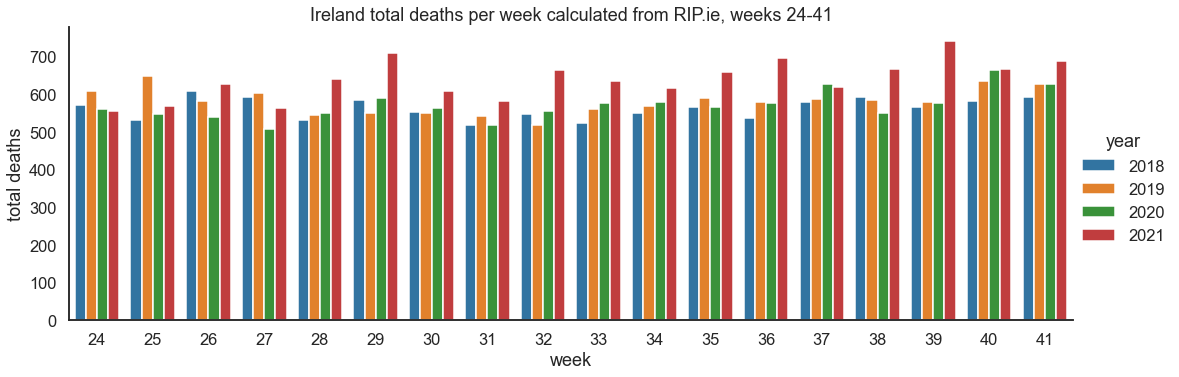

In [94]:
g=df.groupby(['year','week']).agg({'name':np.size}).reset_index()
g=g[(g.week>23) & (g.week<42)]
g = g[g.year>2017]
print (g)
sns.catplot(data=g,x='week',y='name',hue='year',kind='bar',aspect=3.0)
plt.ylabel('total deaths')
plt.title('Ireland total deaths per week calculated from RIP.ie, weeks 24-41')
plt.savefig('ireland_deaths_ripie_byweek.png',dpi=150)

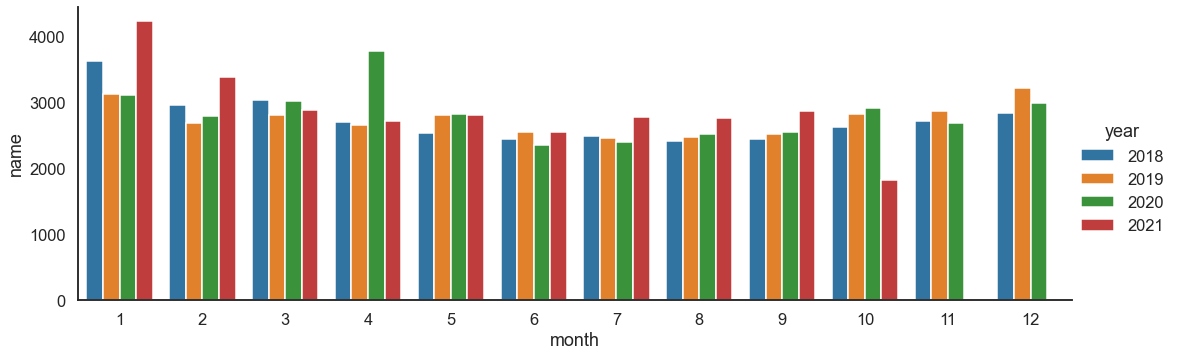

In [67]:
g=df.groupby(['year','month']).agg({'name':np.size}).reset_index()
g=g[g.year>2017]
sns.catplot(data=g,x='month',y='name',hue='year',kind='bar',aspect=3.0)

In [4]:
nhomes = pd.read_csv('nursing_homes.csv')
#print (nhomes[:10])

def find_nhome(x):
    for i,r in nhomes.iterrows():
        if r.shortname in x.notice and x.county == r.county:
            return r['name']+','+r.county

x=df[:160]
#x['home'] = x.apply(lambda x: find_nhome(x),1)
#print (x)

In [19]:
pop = pd.read_csv('ireland_population.csv')
wbcdrt = pd.read_csv('ireland_cdrt.csv')

year
2008     8939
2009     8876
2010     8732
2011     8162
2012     8367
2013     8627
2014     9013
2015     9317
2016     9502
2017     9516
2018     9789
2019    10036
2020     9842
2021    10967
dtype: int64


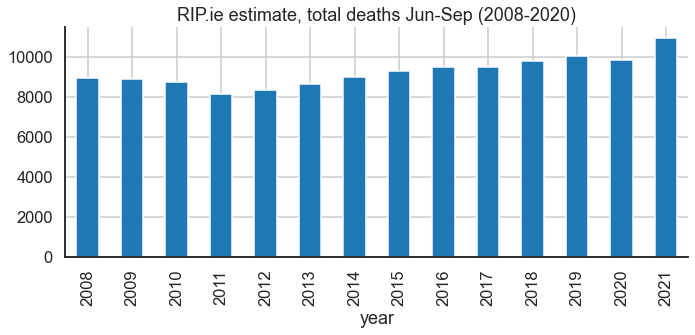

In [93]:
x=df[(df.month<10) & (df.month>5)]
totals = x.groupby('year').agg('size')
print (totals)
ax=totals.plot(kind='bar',grid=True,figsize=(10,5))
plt.title('RIP.ie estimate, total deaths Jun-Sep (2008-2020)')
sns.despine()
plt.tight_layout()
plt.savefig('ireland_deaths_ripie_summary_v3.png',dpi=120)

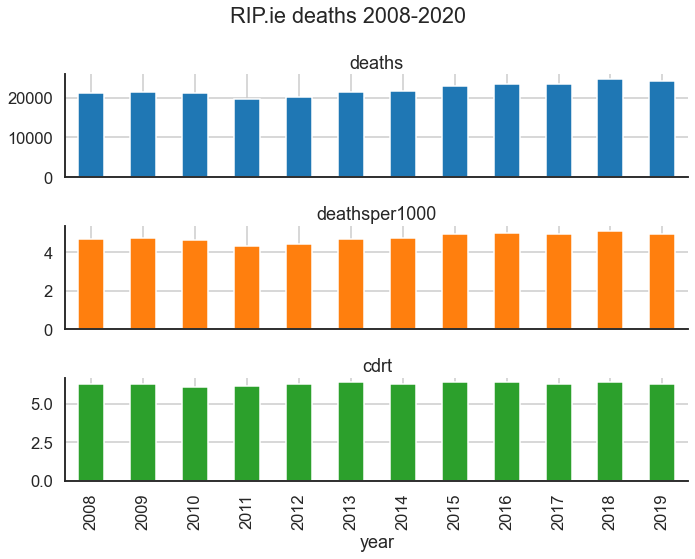

In [20]:
d=pd.DataFrame(totals,columns=['deaths']).reset_index()
d=pop.merge(d,on='year')
d=d.sort_values('year')
d['deathsper1000'] = d.deaths/d['pop']*1e3
d=wbcdrt.merge(d,on='year')
d.plot(x='year',y=['deaths','deathsper1000','cdrt'],kind='bar',subplots=True,grid=True,legend=False,figsize=(10,8))
plt.suptitle('RIP.ie deaths 2008-2020')
sns.despine()
plt.tight_layout()

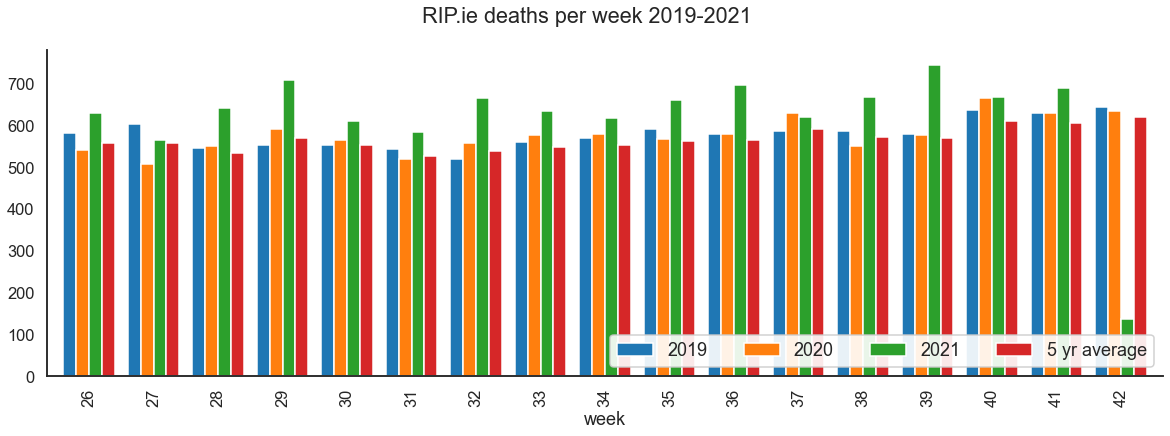

In [83]:
byw = pd.pivot_table(df, index='week',columns='year',values='name',aggfunc='size')
byw['5 yr average'] = byw.iloc[:,8:-1].mean(1)
x=byw.iloc[25:42,11:]
#print (x)
x.plot(kind='bar',width=.8,figsize=(20,6))
#x.T.boxplot(figsize=(18,6))
plt.legend(loc=4,ncol=5,framealpha=0.9,fontsize=18)
plt.suptitle('RIP.ie deaths per week 2019-2021')
sns.despine()
plt.savefig('ireland_deaths_ripie_byweek.png',dpi=150)

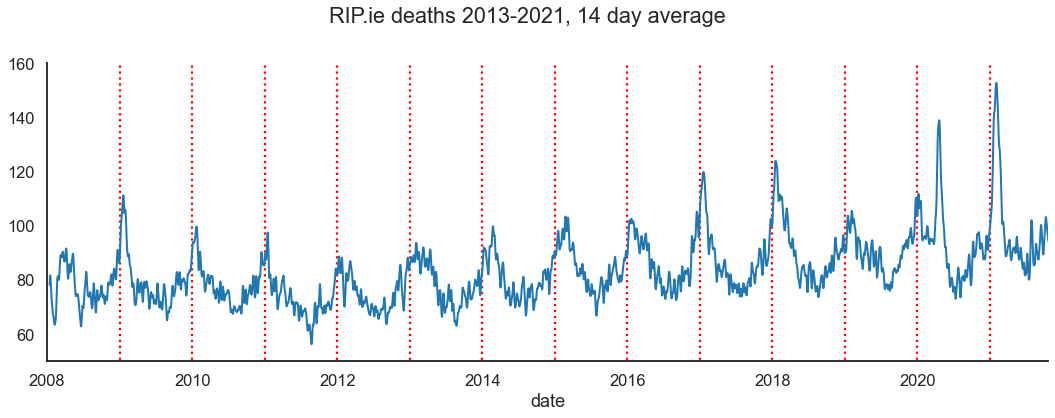

In [70]:
x = df.groupby('date').size()
ax=x.rolling(14,win_type='hamming').mean().plot(lw=2,figsize=(15,6),ylim=(50,160))
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
for y in range(2008,2021):
    ax.vlines(pd.to_datetime('%s-12-31' %y),0,160,color='r',ls=':')

plt.suptitle('RIP.ie deaths 2013-2021, 14 day average')
sns.despine()
plt.tight_layout()
plt.savefig('ireland_deaths_ripie_trend_v2.png',dpi=150)

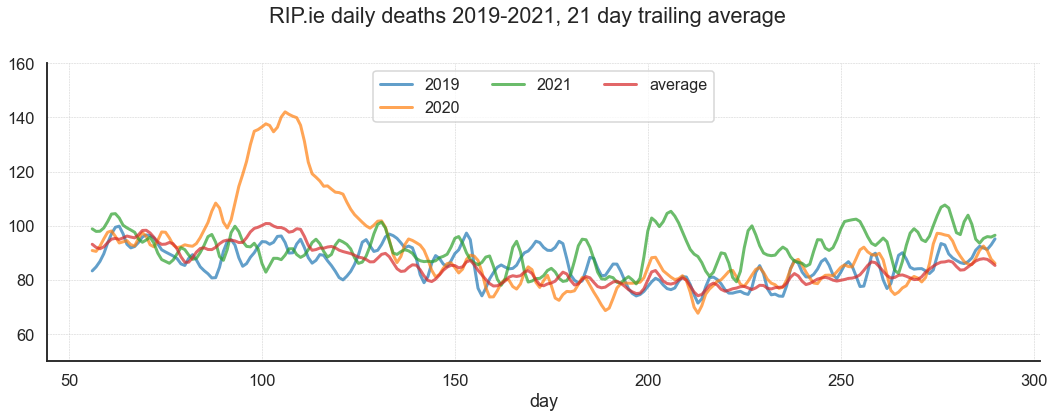

In [77]:
byday = pd.pivot_table(df, index='day',columns='year',values='name',aggfunc='size')
byday['average'] = byday.iloc[:,8:-1].mean(1)
x = byday.iloc[:,11:]
x = x.loc[50:290]
meanday = x.rolling(window=7,win_type='hamming').mean()
ax=meanday.plot(figsize=(15,6),ylim=(50,160),lw=3,alpha=0.7)
ax.grid(linestyle='--',linewidth=.5)
plt.legend(loc=9,ncol=3,fontsize=16)
sns.despine()
plt.suptitle('RIP.ie daily deaths 2019-2021, 21 day trailing average')
plt.tight_layout()
plt.savefig('ireland_deaths_ripie_compared_mean_v2.png',dpi=150)


## GRO compare

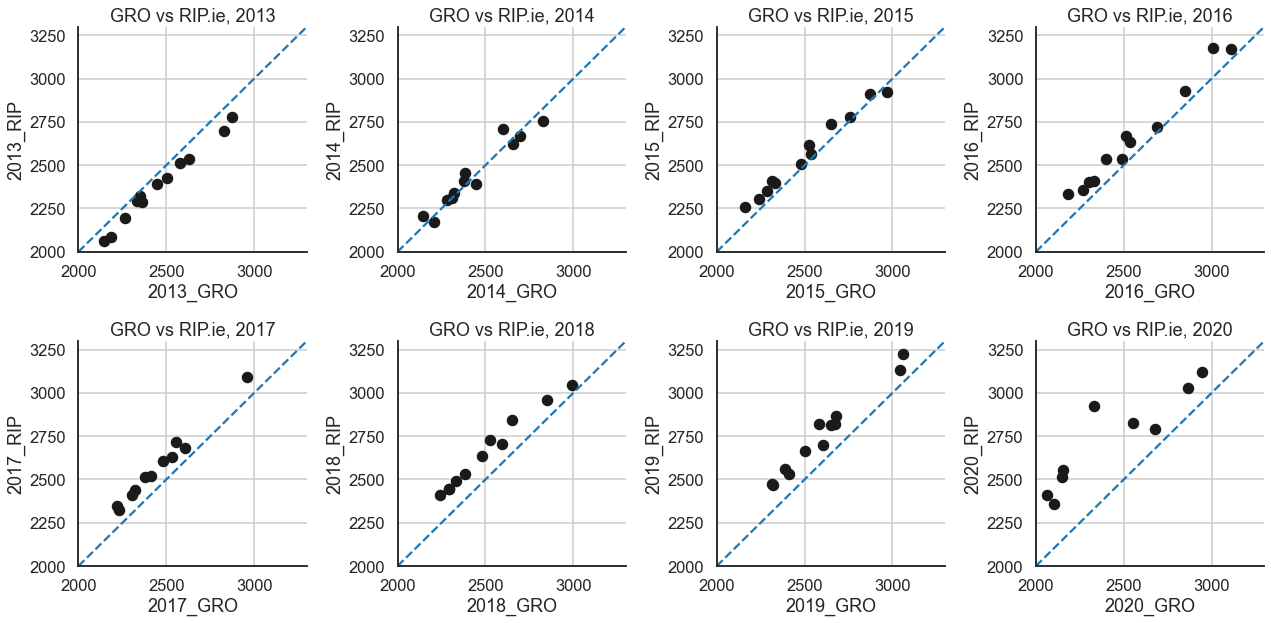

In [80]:
gro = pd.read_csv('gro_deaths.csv')
bymonth = pd.pivot_table(df, index='month',columns='year',values='name',aggfunc='size')
a=bymonth.reset_index()
a.columns=[str(i) for i in a.columns]
b=gro.merge(a,on='month',suffixes=['_GRO','_RIP'])
#print (b)
f,axs=plt.subplots(2,4,figsize=(18,9))
axs=axs.flat
i=0
for y in range(2013,2021):
    ax=axs[i]
    b.plot(x='%s_GRO' %y,y='%s_RIP' %y,c='0.1',s=100,kind='scatter',grid=True,ax=ax)
    ax.plot([2000, 3300], [2000, 3300], ls='--')
    ax.set_xlim(2000,3300)
    ax.set_ylim(2000,3300)
    ax.set_title('GRO vs RIP.ie, %s' %y)
    i+=1
sns.despine()
plt.tight_layout()
plt.savefig('ireland_deaths_gro_vs_ripie.png',dpi=150)

## compare eurostat data

In [30]:
eu=pd.read_csv('estat_demo_r_mwk_ts_filtered.tsv',sep='\t').T
eu.columns=['Eurostat']
eu[-4:]

,Eurostat
2021-W32,608
2021-W33,584
2021-W34,566
2021-W35,534


          RIP.ie  Eurostat
2020-W51     657       614
2020-W52     699       628
2020-W53     429       672
2021-W01     859       789
2021-W02     988       906
2021-W03    1060       975
2021-W04    1034       971
2021-W05     961       890
2021-W06     902       834
2021-W07     813       752
2021-W08     707       671
2021-W09     679       625
2021-W10     644       582
2021-W11     620       571
2021-W12     639       586
2021-W13     670       622
2021-W14     617       567
2021-W15     628       591
2021-W16     630       589
2021-W17     648       591


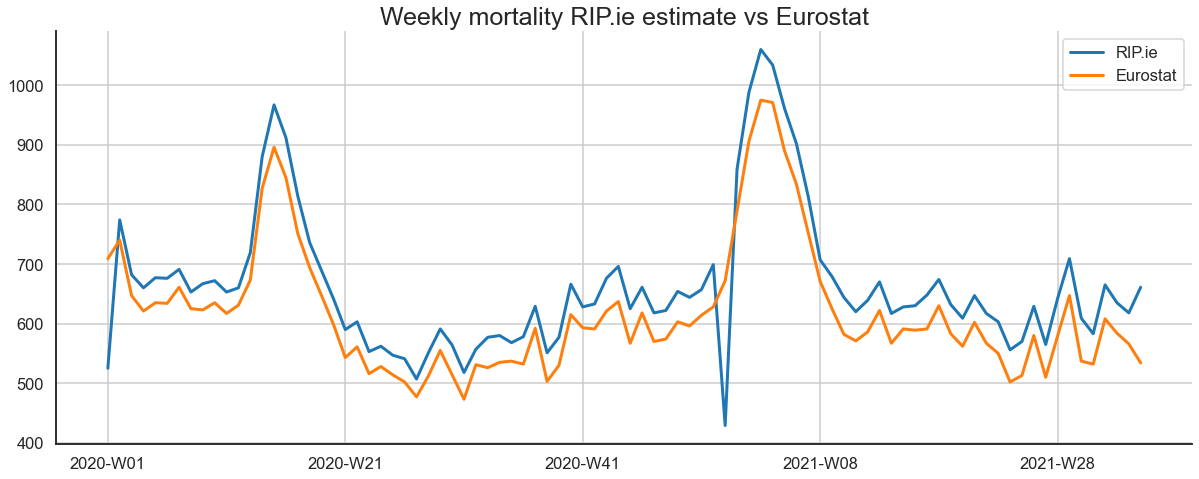

In [92]:
x = df.groupby(['year','week']).size().reset_index()
x['time'] = x.apply(lambda x: '%s-W%02d' %(x.year,x.week),1)
x=x.set_index('time').iloc[:,2:]
x.columns=['RIP.ie']
x=x.merge(eu,left_index=True, right_index=True,how='right')
#x['diff'] = x.RIP-x.Eurostat
print (x[50:70])
fig,ax=plt.subplots(1,1,figsize=(17,7))
ax=x.plot(lw=3,ax=ax,grid=True)
sns.despine()
plt.tight_layout()
plt.title('Weekly mortality RIP.ie estimate vs Eurostat',fontsize=25)
#ax2 = fig.add_axes( [0.4, 0.6, 0.15, 0.3])
#x.plot(x='Eurostat',y='RIP.ie',kind='scatter',c='black',ax=ax2)
plt.tight_layout()
fig.savefig('eurostat_ireland_deaths_compared.png')

## person matching

In [51]:
df = get_data(dups=True)
sub = df[(df.address.str.contains('Dublin')) | (df.county=='Dublin')]
print (len(sub))
sub.to_pickle('rip_dublin.pkl')

443385
146559


In [ ]:
test = sub[sub.address.str.contains('Dublin')][['name','address','date']].sample(20)
#test['address'] = test.address.apply(lambda x: '+'.join(x.strip().split(',')))
test

In [23]:
x=df[df.name.str.contains("'")]
x[:10].name.apply(clean_name)

451932    Rita  O Donnell (née Nugent)
451934               Tony  O Callaghan
451948     Esther  Murphy (née O Hare)
451985             Patricia  O Doherty
451997     Humphrey (Free)  O Sullivan
451999              Catherine  O Regan
452003                 Gerald  O Flynn
452004                  John  O Connor
452009    Rita  Keane (née O Sullivan)
452021    Mary  Power (née O Flanagan)
Name: name, dtype: object

In [ ]:
def clean_name(txt):
    clean = re.sub(r"""[,.;@#?!&$']+ \ * """, " ", 
                   txt, flags=re.VERBOSE)
    clean = clean.strip()
    return clean

def find_word(w):
    return re.compile(r'\b({0})\b'.format(w), flags=re.IGNORECASE).search

def find_match(x,r): 
    name = clean_name(x['name'])
    name = name.lower()
    if r.surname.lower() in name and find_word(r.firstname)(name): #r.firstname.lower() in name:        
        return True
    return False

def run_search(db, targets, keep=1):
    """Search rip.ie table for known persons"""
    
    print ('searching %s rows' %len(db))
    results = []
    for i,r in targets.iterrows():
        print (r.case_id,r.surname,r.firstname)
        A = r.address
        f = db.apply(lambda x: find_match(x,r),1)
        res = db[f].copy()   
        if len(res) == 0:
            print ('no names match')
            res=pd.DataFrame([(r.case_id,0,'NA')],columns=['case_id','year','id'])
            print (res)            
        elif len(res) == 1:
            print ('one unique hit')
            #res = res.iloc[0]
        else:
            #get best match address
            print ('found %s hits' %len(res))
            addresses=list(res.address)            
            #res['score']=res.apply(lambda x: fuzz.ratio(A, x.address),1)
            res['score']=res.apply(lambda x: difflib.SequenceMatcher(None, A, x.address).ratio(),1)
            res = res.sort_values('score',ascending=False)
            res = res[:keep]
            #res = res.iloc[0]
        res['case_id'] = r.case_id
        results.append(res)
    
    results = pd.concat(results).reset_index(drop=True)
    return results

targets = pd.read_csv('test_targets.csv')
results = run_search(sub, targets, keep=1)
results = targets.merge(results,on='case_id')
results

In [25]:
results.to_csv('search_results.csv',index=False)